In [ ]:
# Example takend and adapted from:
# https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944
# Data from: https://www.kaggle.com/darkknight91/ge-stock

In [ ]:
#Libraries
import io
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parte 1: Carga y limpia los datos

In [ ]:
#URL to read data
url="https://raw.githubusercontent.com/Yalidt/DeepLearning/main/MiniProyectos/ge.us.txt?raw=true"
rurl=requests.get(url).content

# Read data to pandas
df = pd.read_csv(io.StringIO(rurl.decode('utf-8')))

In [ ]:
# Drop NA's
df.dropna(inplace=True)
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0
...,...,...,...,...,...,...,...
14053,2017-11-06,20.5200,20.5300,20.0800,20.1300,60641787,0
14054,2017-11-07,20.1700,20.2500,20.1200,20.2100,41622851,0
14055,2017-11-08,20.2100,20.3200,20.0700,20.1200,39672190,0
14056,2017-11-09,20.0400,20.0710,19.8500,19.9900,50831779,0


In [ ]:
# Checking for NaN values.
print("checking if any null values are present\n", df.isna().sum())

checking if any null values are present
 Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64


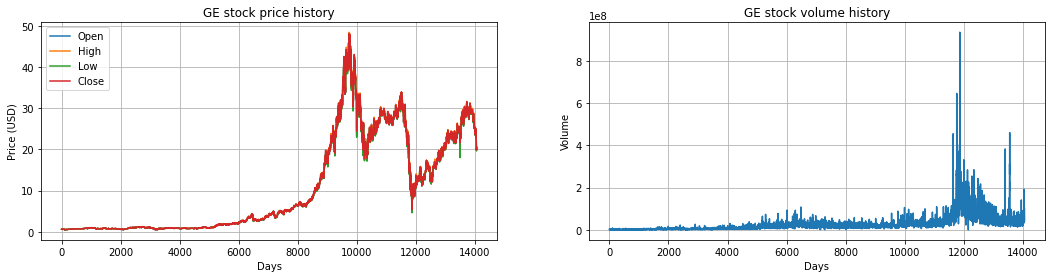

In [ ]:
# Plot info
plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.plot(df["Open"])
plt.plot(df["High"])
plt.plot(df["Low"])
plt.plot(df["Close"])
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df["Volume"])
plt.title('GE stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.grid()
plt.show()

In [ ]:
# Split train and test sets
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), "--", len(df_test))
# Still in DataFrame format

Train and Test size 11246 -- 2812


In [ ]:
# Scale features and put them in matrix format (DataFrame --> Matrix)
from sklearn.preprocessing import MinMaxScaler

useful_cols = ["Open", "High", "Low", "Close", "Volume"]
X = df_train.loc[:, useful_cols].values
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X)
X_test = min_max_scaler.transform(df_test.loc[:, useful_cols]) #transform the test with the train fit

# Here we have two sets. One with 11246 timesteps, each of 5 features, and other
# with 2812 timesteps, each of 5 features
print(X_train.shape)
print(X_test.shape)

(11246, 5)
(2812, 5)


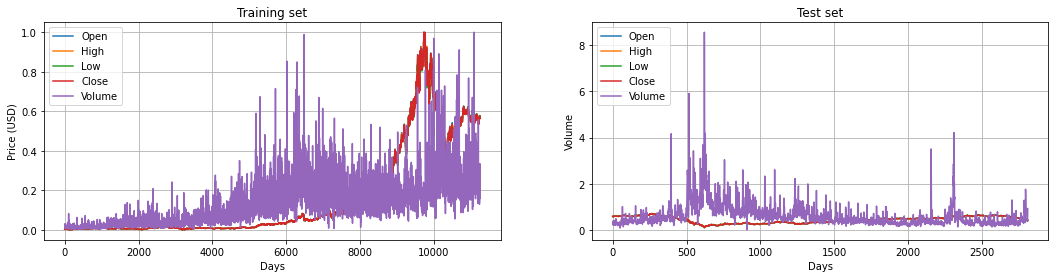

In [ ]:
# Plot info
plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.plot(X_train)
plt.title('Training set')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close', 'Volume'], loc='upper left')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(X_test)
plt.title('Test set')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close', 'Volume'], loc='upper left')
plt.grid()
plt.show()

# Parte 2: Formatea los datos para procesarlos con RNNs

In [ ]:
# GOAL:
# Predict 'close' value, from 4 historic timesteps,
# close[t] = f(x[t-1] ,x[t-2], x[t-3], x[t-4]; \Omega),
# where x[t] = [open, high, low, close, volume][t]

In [ ]:
# AUX funtion to build time-series dataset
def build_dataset(X, Y, hist_size):
  '''
  Params
    X: data matrix [n_time_steps, n_X_feats]
    Y: label matrix [n_time_steps, n_Y_feats]
    hist_size: integer indicating the number of time steps in each sample of x
  Returns
    x: tensor of input data [n_samples, n_timesteps, n_X_features]
    y: tensor of output data [n_samples, n_Y_features]
  '''
  n_samples = Y.shape[0] - hist_size
  x = np.zeros((n_samples, hist_size, X.shape[1])) #parameters :num vectors, n rows, n columns
  y = np.zeros((n_samples))

  for ind in range(n_samples):    
    x[ind] = X[ind : ind + hist_size]
    y[ind] = Y[ind + hist_size]
  return x, y

El objetivo de esta función es cambiar el formato de la serie de tiempo, que será nuestro input. Es algo parecido a promedio móviles, como se pide tener el histórico de 4 datos eso va haciendo manteniendo 4 siempre y quitando el mas viejo.

In [ ]:
# Create time-series datasets: Use all features as input, and 'close' as output.
time_steps = 4
x_train, y_train = build_dataset(X_train, X_train[:, 3], time_steps) #X_train[:, 3] all rows from 3 column #Close is the target
x_test,  y_test  = build_dataset(X_test,  X_test[:, 3],  time_steps)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(11242, 4, 5)
(2808, 4, 5)
(11242,)
(2808,)


In [ ]:
# Print some examples
print("Original first elements")
print(X_train[:10])
print("\nTime-series format of first elements x")
print(x_train[:4])
print("\nTime-series format of first elements y")
print(y_train[:4])

Original first elements
[[0.00356678 0.00352766 0.00358385 0.00338425 0.02108267]
 [0.00340607 0.00319219 0.00341628 0.00338425 0.01365459]
 [0.00340607 0.00319219 0.00323598 0.00321827 0.01758709]
 [0.00323903 0.00302758 0.00272904 0.00287161 0.02730914]
 [0.00289013 0.00268378 0.0025551  0.00287161 0.03135089]
 [0.00289013 0.00285047 0.00289873 0.00287161 0.02293968]
 [0.00289013 0.00285047 0.00306629 0.00287161 0.01889791]
 [0.00289013 0.00268378 0.00289873 0.00287161 0.01529311]
 [0.00289013 0.00285047 0.00289873 0.00270563 0.01594855]
 [0.00289013 0.00268378 0.00306629 0.00287161 0.02064569]]

Time-series format of first elements x
[[[0.00356678 0.00352766 0.00358385 0.00338425 0.02108267]
  [0.00340607 0.00319219 0.00341628 0.00338425 0.01365459]
  [0.00340607 0.00319219 0.00323598 0.00321827 0.01758709]
  [0.00323903 0.00302758 0.00272904 0.00287161 0.02730914]]

 [[0.00340607 0.00319219 0.00341628 0.00338425 0.01365459]
  [0.00340607 0.00319219 0.00323598 0.00321827 0.01758709]

# Parte 3: Crea la RNN y entrenala

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Dropout
import tensorflow as tf

In [ ]:
# == Q1 == 
# Usando la siguiente estructura de red recurrente, encuentra el modelo más sencillo posible
# que de buenos resultados: la red con el menor número de parámetros.

# Modelo Base

In [ ]:
x_train.shape

(11242, 4, 5)

In [ ]:
rnn_model = Sequential()
rnn_model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
rnn_model.add(SimpleRNN(units=256))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 256)               67072     
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 67,329
Trainable params: 67,329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile
rnn_model.compile(loss='mse', optimizer='rmsprop')

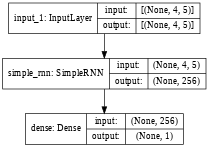

In [ ]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(rnn_model, show_shapes=True, show_layer_names=True,
                          rankdir='TB', expand_nested=True, dpi=48)

In [ ]:
# Weights in the first layer (simpleRNN, Input does not count as layer)
A, B, C = rnn_model.layers[0].get_weights()
print(A.shape)
print(B.shape)
print(C.shape)

# == Q2 == 
# Renombra los ndarrays A, B, C, usando la notación vista en clase: Wh, Wx, b.

(5, 256)
(256, 256)
(256,)


In [ ]:
# Weights in the second layer (FullyConnected)
W, b = rnn_model.layers[1].get_weights()
print(W.shape)
print(b.shape)

(256, 1)
(1,)


In [ ]:
# Train
history = rnn_model.fit(x_train, y_train, epochs=10, batch_size=256, validation_split=0.1)

Epoch 1/10
40/40 [==============================] - 2s 31ms/step - loss: 0.0452 - val_loss: 0.0354
Epoch 2/10
40/40 [==============================] - 1s 16ms/step - loss: 0.0053 - val_loss: 0.0132
Epoch 3/10
40/40 [==============================] - 1s 17ms/step - loss: 0.0030 - val_loss: 0.0406
Epoch 4/10
40/40 [==============================] - 1s 17ms/step - loss: 0.0031 - val_loss: 0.0083
Epoch 5/10
40/40 [==============================] - 1s 17ms/step - loss: 0.0024 - val_loss: 0.0093
Epoch 6/10
40/40 [==============================] - 1s 17ms/step - loss: 0.0020 - val_loss: 0.0069
Epoch 7/10
40/40 [==============================] - 1s 17ms/step - loss: 0.0020 - val_loss: 3.8776e-04
Epoch 8/10
40/40 [==============================] - 1s 17ms/step - loss: 0.0016 - val_loss: 2.7981e-04
Epoch 9/10
40/40 [==============================] - 1s 18ms/step - loss: 0.0013 - val_loss: 0.0183
Epoch 10/10
40/40 [==============================] - 1s 17ms/step - loss: 0.0015 - val_loss: 5.4416e-

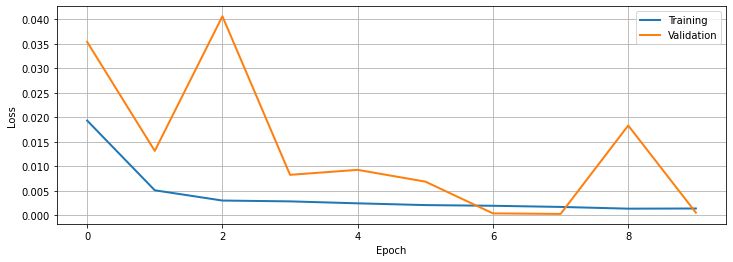

In [ ]:
# Plot loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
# Predict on training and test sets
y_train_hat = rnn_model.predict(x_train)
y_test_hat = rnn_model.predict(x_test)
print(y_train_hat.shape)
print(y_test_hat.shape)

(11242, 1)
(2808, 1)


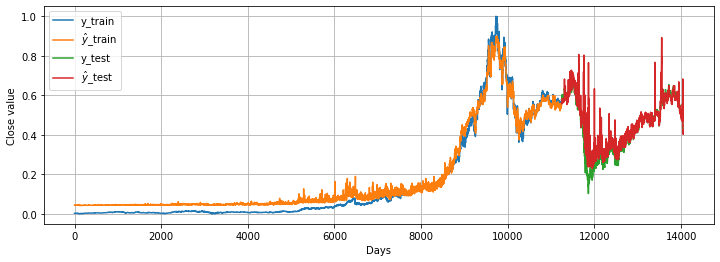

In [ ]:
# Plot y_train, y_train_hat, y_test and y_test_hat
x_ticks = np.arange(len(y_train) + len(y_test)) # Para poder imprimir test delante de train

plt.figure(figsize=(12, 4))
plt.plot(x_ticks[:len(y_train)], y_train)
plt.plot(x_ticks[:len(y_train)], y_train_hat)
plt.plot(x_ticks[len(y_train):], y_test)
plt.plot(x_ticks[len(y_train):], y_test_hat)
plt.ylabel('Close value')
plt.xlabel('Days')
plt.legend(['y_train', '$\hat{y}$_train', 'y_test', '$\hat{y}$_test'], loc='upper left')
plt.grid()
plt.show()

# Pruebas Modelos

Modelo 1 : 1 capa RNN y 3 capas densas

In [ ]:
def get_model_arquitecture(model, x_train, y_train):
  """Function to get the model arquitecture """

  if model == 1:
    #Base line model
    RNN = Sequential()
    RNN.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
    RNN.add(SimpleRNN(units=256))
    RNN.add(Dense(1, activation='sigmoid'))
      
  elif model == 2:
    #Model 2 : 1 capa RNN, 1 dropout y  1 capa densa
    RNN = Sequential()
    RNN.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
    RNN.add(SimpleRNN(units=128, activation='relu'))
    RNN.add(Dropout(0.5))
    RNN.add(Dense(1, activation='sigmoid'))

  elif model == 3:
    #Model 3 : 2 capas RNN , 1 dropout y 1 capa densa
    RNN = Sequential()
    RNN.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
    RNN.add(SimpleRNN(units=128, activation='relu',return_sequences=True))
    RNN.add(Dropout(0.5))
    RNN.add(SimpleRNN(units=64, activation='relu'))
    RNN.add(Dense(1, activation='sigmoid'))

  elif model == 4:
    #Model 4 : 1 capa RNN y 3 capas densas
    RNN = Sequential()
    RNN.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
    RNN.add(SimpleRNN(units=128, activation='relu'))
    RNN.add(Dense(units=64, activation='relu'))
    RNN.add(Dense(units=128))
    RNN.add(Dense(1, activation='sigmoid'))

  elif model == 5:
    #Model 5 : 2 capa RNN, 1 dropout y  1 capa densa
    RNN = Sequential()
    RNN.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
    RNN.add(SimpleRNN(units=64, activation='relu',return_sequences=True))
    RNN.add(Dropout(0.5))
    RNN.add(SimpleRNN(units=32, activation='relu'))
    RNN.add(Dense(1, activation='sigmoid'))

  else:
   #Model 6 : 2 capa RNN y  1 capa densa
    RNN = Sequential()
    RNN.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
    RNN.add(SimpleRNN(units=32, activation='relu',return_sequences=True))
    RNN.add(SimpleRNN(64,return_sequences=True))
    RNN.add(Dense(28))
    RNN.add(Dense(1, activation='sigmoid'))

  return RNN

In [ ]:
RNN = Sequential()
RNN.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
RNN.add(SimpleRNN(units=64, activation='relu',return_sequences=True))
RNN.add(Dropout(0.5))
RNN.add(SimpleRNN(units=32, activation='relu'))
RNN.add(Dense(1, activation='sigmoid'))

In [ ]:
def eval_models(x_train, y_train):

  bs = [128, 128, 264, 128, 264,128]
  models = [1,2,3,4,5,6]
  n_epochs = 20
  loss_train = []
  loss_validation = []
  model = []
  pars = []

  for md,batch_s in zip(models,bs):
    model.append(md)
    RNN = get_model_arquitecture(md,x_train, y_train)
    RNN.compile(loss='mse', optimizer='rmsprop')

    #Train model
    history = RNN.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_s, validation_split=0.1)

    # Compute test loss 
    loss_train.append(RNN.history.history['loss'][-1])
    loss_validation.append(RNN.history.history['val_loss'][-1])
    
    pars.append(RNN.count_params())
    # Reset session
    tf.keras.backend.clear_session()
    
  table={'model':model, 'loss_train':loss_train,'loss_validation':loss_validation, 'params':pars}       
  results=pd.DataFrame(table)
    
  return results

In [ ]:
results_1 = eval_models(x_train, y_train)

In [ ]:
results_1  #gana modelo 2

,model,loss_train,loss_validation,params
0,1,0.000344,0.000271,67329
1,2,0.000430,0.000166,17281
2,3,0.000258,0.000824,29569
3,4,0.000093,0.000224,33857
4,5,0.000289,0.000198,7617
5,6,0.000128,0.000340,9273


In [ ]:
results_2 = eval_models(x_train, y_train)

In [ ]:
results_2  #gana modelo 4

,model,loss_train,loss_validation,params
0,1,0.000368,0.000353,67329
1,2,0.000394,0.003681,17281
2,3,0.000281,0.000700,29569
3,4,0.000102,0.000140,33857
4,5,0.000291,0.000769,7617
5,6,0.000136,0.003046,9273


In [ ]:
results_3 = eval_models(x_train, y_train)

In [ ]:
results_3 #gano modelo 5

,model,loss_train,loss_validation,params
0,1,0.000426,0.003641,67329
1,2,0.000409,0.000676,17281
2,3,0.000289,0.001458,29569
3,4,0.000091,0.002706,33857
4,5,0.000306,0.000614,7617
5,6,0.000148,0.000797,9273


In [ ]:
results_4 = eval_models(x_train, y_train)

In [ ]:
results_4 #gano modelo 1

,model,loss_train,loss_validation,params
0,1,0.000337,0.000498,67329
1,2,0.000404,0.000538,17281
2,3,0.000261,0.001100,29569
3,4,0.000107,0.001498,33857
4,5,0.000391,0.000284,7617
5,6,0.000122,0.004088,9273


In [ ]:
results_5 = eval_models(x_train, y_train)

In [ ]:
results_5  #gano modelo 4

,model,loss_train,loss_validation,params
0,1,0.000348,0.005630,67329
1,2,0.000408,0.002378,17281
2,3,0.000244,0.002479,29569
3,4,0.000094,0.000174,33857
4,5,0.000313,0.001030,7617
5,6,0.000121,0.000470,9273


Promedio de las pruebas (corridas)

In [ ]:
# Append all models
models = results_1.append([results_2, results_3, results_4, results_5],ignore_index=True)

# Mean per model
models.groupby('model').mean()

,loss_train,loss_validation,params
model,,,
1,0.000365,0.002079,67329
2,0.000409,0.001488,17281
3,0.000266,0.001312,29569
4,0.000097,0.000948,33857
5,0.000318,0.000579,7617
6,0.000131,0.001748,9273


# Desempeño modelo 5

De acuerdo al promedio de las 5 corridas se obtiene una menos pérdida en validación con el modelo #5, cuya arquitectura es la siguiente:

In [ ]:
RNN_model = Sequential()
RNN_model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
RNN_model.add(SimpleRNN(units=64, activation='relu',return_sequences=True))
RNN_model.add(Dropout(0.5))
RNN_model.add(SimpleRNN(units=32, activation='relu'))
RNN_model.add(Dense(1, activation='sigmoid'))

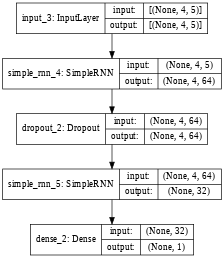

In [ ]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(RNN_model, show_shapes=True, show_layer_names=True,
                          rankdir='TB', expand_nested=True, dpi=48)

In [ ]:
# Compile
RNN_model.compile(loss='mse', optimizer='rmsprop')

In [ ]:
# Weights in the first layer (simpleRNN, Input does not count as layer)
A, B, C = RNN_model.layers[0].get_weights()
print(A.shape)
print(B.shape)
print(C.shape)

(5, 64)
(64, 64)
(64,)


In [ ]:
# == Q2 == 
# Renombra los ndarrays A, B, C, usando la notación vista en clase: Wh, Wx, b.
Wh, Wx, b = RNN_model.layers[0].get_weights()
print(Wh.shape)
print(Wx.shape)
print(b.shape)

(5, 64)
(64, 64)
(64,)


In [ ]:
# Weights in the second layer (FullyConnected)
W, b = RNN_model.layers[3].get_weights()
print(W.shape)
print(b.shape)

(32, 1)
(1,)


In [ ]:
# Train
history = RNN_model.fit(x_train, y_train, epochs=20, batch_size=264, validation_split=0.1)

Epoch 1/20
39/39 [==============================] - 2s 15ms/step - loss: 0.0923 - val_loss: 0.0102
Epoch 2/20
39/39 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.0260
Epoch 3/20
39/39 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 4/20
39/39 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0085
Epoch 5/20
39/39 [==============================] - 0s 8ms/step - loss: 9.8439e-04 - val_loss: 6.0070e-04
Epoch 6/20
39/39 [==============================] - 0s 8ms/step - loss: 8.2504e-04 - val_loss: 5.8136e-04
Epoch 7/20
39/39 [==============================] - 0s 8ms/step - loss: 7.0020e-04 - val_loss: 4.9555e-04
Epoch 8/20
39/39 [==============================] - 0s 8ms/step - loss: 6.4844e-04 - val_loss: 0.0043
Epoch 9/20
39/39 [==============================] - 0s 9ms/step - loss: 5.8930e-04 - val_loss: 6.5601e-04
Epoch 10/20
39/39 [==============================] - 0s 8ms/step - loss: 5.1766e-

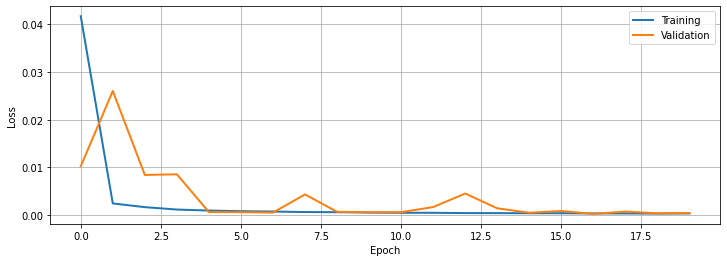

In [ ]:
# Plot loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
# == Q3 ==
# El rendimiento es excelente, sin embargo, hay un detalle (¿problema?) de dependencia en los datos.
# ¿Puedes notar cuál es, y explicar el excelente rendimiento?

Si existe dependencia de los datos, de hecho se realizó una función auxiliar que nos ayuda a mantener los últimos 4 datos para con esos hacer la predicción. Por otro lado, el excelente desempeño es porque es una serie de tiempo con cierta tendencia que va incrementando poco a poco a lo largo del tiempo y los últimos 4 datos si estan funcionando para la predicción, logran capturar la tendencia pasada para su pronóstico futuro. Del mismo modo, es importante mencionar que el tensor X's tiene incluído la variable target,por eso también de tiene un muy buen rendimiento.

In [ ]:
# == Q4 ==
# Revisa la documentación de tensorflow, y explica la diferencia entre los layers RNN y SimpleRNN.

RNN es una clase de keras que contiene 3 tipos de capas integradas:
+ keras.layers.SimpleRNN 

+ keras.layers.GRU  

+ keras.layers.LSTM 

SimpleRNN hereda de la clase RNN y es una red completamente conectada (fully conected) donde el output es despues alimentado como input. 

# Parte 4: Predice con "delay"

In [ ]:
# == Q5 ==
# A continuación se presenta la función "delayed_dataset", la cual formatea los datos para asociar y[t] con
# x[t-delay] hasta x[t-delay-history]. Por ejemplo, para hacer prónosticos del tipo
# y[10] = f(x[7], x[6], x[5]; \Omega). Donde tanto x como y pueden ser univariados o multivariados.
#
# For instance, calling such a function with the 
# x_train, y_train = delayed_dataset(X_train[:20, :3], X_train[:20, 3:], delay=2, hist=4)
# must return x_train and y_train with the following shapes,
# x_train.shape = (14, 4, 3) # 14 samples, each of 4 time-steps, each of 3 features
# y_train.shape = (14, 2)    # 14 label-samples, each of two values
#
# The following table shows indices information (not need to print it)
# IND:  0, Xids:  0 --  3, -- Yids:  5
# IND:  1, Xids:  1 --  4, -- Yids:  6
# IND:  2, Xids:  2 --  5, -- Yids:  7
# IND:  3, Xids:  3 --  6, -- Yids:  8
# IND:  4, Xids:  4 --  7, -- Yids:  9
# IND:  5, Xids:  5 --  8, -- Yids: 10
# IND:  6, Xids:  6 --  9, -- Yids: 11
# IND:  7, Xids:  7 -- 10, -- Yids: 12
# IND:  8, Xids:  8 -- 11, -- Yids: 13
# IND:  9, Xids:  9 -- 12, -- Yids: 14
# IND: 10, Xids: 10 -- 13, -- Yids: 15
# IND: 11, Xids: 11 -- 14, -- Yids: 16
# IND: 12, Xids: 12 -- 15, -- Yids: 17
# IND: 13, Xids: 13 -- 16, -- Yids: 18

In [ ]:
# AUX funtion to build time-series dataset
def delayed_dataset(X, Y, delay, hist_size):
  '''
  Params
    X: data matrix [n_time_steps, n_X_feats]
    Y: label matrix [n_time_steps, n_Y_feats]
    delay: integer indicating the delay between last time step in x and time step in y
    hist_size: integer indicating the number of time steps in each sample of x
  Returns
    x: tensor of input data [n_samples, n_timesteps, n_X_features]
    y: tensor of output data [n_samples, n_Y_features]
  '''
  n_samples = Y.shape[0] - (delay + hist_size)
  x = np.zeros((n_samples, hist_size, X.shape[1]))
  y = np.zeros((n_samples, Y.shape[1]))

  for ind in range(n_samples):    
    x[ind] = X[ind : ind + hist_size]
    y[ind] = Y[ind + hist_size + delay]
  return x, y

In [ ]:
# Usa la función anterior para generar sets de entrenamiento y validación donde,
# x contenga (open, high, low), e y contenga (close, volume)

delay=7
history_size=7

x_train, y_train = delayed_dataset(X_train[:,0:3], X_train[:, 3:5], delay, history_size)
x_test, y_test = delayed_dataset(X_test[:,0:3], X_test[:, 3:5], delay, history_size)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(11232, 7, 3)
(2798, 7, 3)
(11232, 2)
(2798, 2)


In [ ]:
# == Q6 ==
# Diseña una RNN para resolver el problema de regresion multivariada que acabas de generar.
# Reporta el mejor resultado que hayas obtenido y la red que lo haya generado

La mejor RNN definida para resolver el problema de regresión multivariado es la siguiente:

In [ ]:
# Your RNN Here
rnn_model = Sequential()
rnn_model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
#256
rnn_model.add(SimpleRNN(units=32, activation='relu',return_sequences=False))
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(2, activation='sigmoid'))

rnn_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_16 (SimpleRNN)    (None, 32)                1152      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 66        
Total params: 1,218
Trainable params: 1,218
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile
rnn_model.compile(loss='mse', optimizer='rmsprop')

In [ ]:
# Train
history = rnn_model.fit(x_train, y_train, epochs=10, batch_size=256, validation_split=0.1)

Epoch 1/10
40/40 [==============================] - 1s 10ms/step - loss: 0.1589 - val_loss: 0.0888
Epoch 2/10
40/40 [==============================] - 0s 4ms/step - loss: 0.0456 - val_loss: 0.0091
Epoch 3/10
40/40 [==============================] - 0s 5ms/step - loss: 0.0164 - val_loss: 0.0073
Epoch 4/10
40/40 [==============================] - 0s 5ms/step - loss: 0.0116 - val_loss: 0.0065
Epoch 5/10
40/40 [==============================] - 0s 5ms/step - loss: 0.0094 - val_loss: 0.0065
Epoch 6/10
40/40 [==============================] - 0s 5ms/step - loss: 0.0079 - val_loss: 0.0071
Epoch 7/10
40/40 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0072
Epoch 8/10
40/40 [==============================] - 0s 5ms/step - loss: 0.0064 - val_loss: 0.0087
Epoch 9/10
40/40 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 0.0087
Epoch 10/10
40/40 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.0080


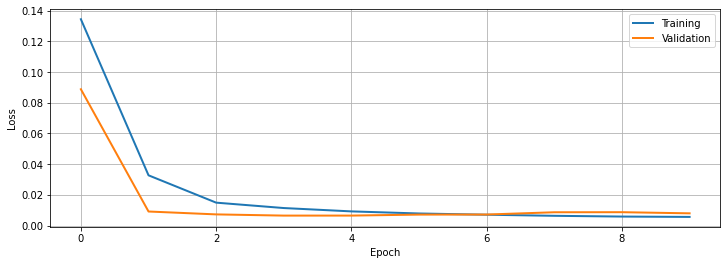

In [ ]:
# Plot loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
loss_train = []
loss_validation = []
pars = []

# Compute test loss 
loss_train.append(rnn_model.history.history['loss'][-1])
loss_validation.append(rnn_model.history.history['val_loss'][-1])
    
pars.append(rnn_model.count_params())
table={'loss_train':loss_train,'loss_validation':loss_validation, 'params':pars}       
results_=pd.DataFrame(table)

El resultado del mejor modelo definido para el problema de regresión multivariado es el siguiente:

In [ ]:
results_

,loss_train,loss_validation,params
0,0.005618,0.007952,1218


In [ ]:
# Predict on training and test sets
y_train_hat = rnn_model.predict(x_train)
y_test_hat = rnn_model.predict(x_test)
print(y_train_hat.shape)
print(y_test_hat.shape)

(11232, 2)
(2798, 2)


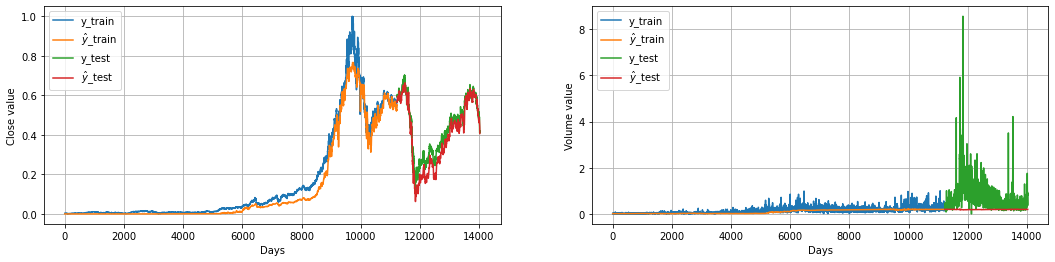

In [ ]:
# Plot y_train, y_train_hat, y_test and y_test_hat
x_ticks = np.arange(len(y_train) + len(y_test))

plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.plot(x_ticks[:len(y_train)], y_train[:, 0])
plt.plot(x_ticks[:len(y_train)], y_train_hat[:, 0])
plt.plot(x_ticks[len(y_train):], y_test[:, 0])
plt.plot(x_ticks[len(y_train):], y_test_hat[:, 0])
plt.ylabel('Close value')
plt.xlabel('Days')
plt.legend(['y_train', '$\hat{y}$_train', 'y_test', '$\hat{y}$_test'], loc='upper left')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x_ticks[:len(y_train)], y_train[:, 1])
plt.plot(x_ticks[:len(y_train)], y_train_hat[:, 1])
plt.plot(x_ticks[len(y_train):], y_test[:, 1])
plt.plot(x_ticks[len(y_train):], y_test_hat[:, 1])
plt.ylabel('Volume value')
plt.xlabel('Days')
plt.legend(['y_train', '$\hat{y}$_train', 'y_test', '$\hat{y}$_test'], loc='upper left')
plt.grid()

plt.show()

In [ ]:
# == Q7 ==
# Parece que predecir 'close' es muy fácil, pero no predecir 'volume'.
# Explica las razones por las cuales crees que obtienes esos resultados.

Se utilizaron diferentes parámetros de 'delay' e 'history_size' y para cada uno de ellos la prediccion de 'close' se adecuaba de mejor manera a los datos reales; mientras que para 'volume' no sucedía esto. Por lo que el spam de tiempo considerado no afectaba considerablemente el desempeño del pronóstico para 'volume',es decir, no mejora sustancialmente.

Además podemos notar en la gráfica de 'close value' que la serie de entrenamiento consideró tanto periodos con altos niveles de la variable respuesta así como caidas en la misma, lo cual es similar a la base de prueba. Mientras que para 'volume value', el periodo de entrenamiento no tiene un comportamiento tan oscilatorio como el de prueba.

Para realizar una mejor predicción de ambas variables se necesita realizar un análisis más profundo de la relación de 'volume' y 'close value' y entender correctamente el comportamiento de 'volumen' despuès de los dias 10,000 ya que tiene crecimientos muy diferentes respecto a su historia.

In [ ]:
# == Q8 ==
# El ejemplo proporcionado contiene una capa tipo SimpleRNN, para la cual no indicamos tipo de activación
# ¿Por qué crees que no lo hacemos?

De acuerdo a la documentación, "Activation function to use. Default: hyperbolic tangent (tanh)." al no seleccionar activación se considera tanh. Referencia: https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN?hl=es 

Como hemos revisado durante el curso, esta función de activación hace referencia a lo siguiente:

*   Tanh: Output layer for regression with−1≤y≤1

Y como escalamos las variables antes de realizar el modelo sabemos que los valores se encuentran dentro de ese rango por lo que la activación puede ser utilizada de acuerdo a la manipulación de los datos hechos anteriormente.

In [ ]:
# == Q9 ==
# La capas tipo SimpleRNN tiene un parámetro "return_sequence" que por defecto es igual a False.
# ¿Qué sucede si lo ponemos igual a True?

Si se deja el default como *True* la capa solo regresará solo la del estado oculto de la última capa, en problemas de regresión o clasificación es lo único que se necesita para utilizarse en la función de activación de salida. Sin embargo en este caso si fue necesario agregar *return_sequence = True* para agregar más capas RNN, lo cual tiene sentido porque necesitamos la salida completa para volver a meterla como input, que es de hecho lo que hace la red recurrente. 